In [52]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
import random
import graph_tool.all as gt

## A classficação será feita para as seguintes redes:

In [140]:
# Biológica
# 1. E. coli transcription network (2002)
GB1 = gt.collection.ns["ecoli_transcription/v1.0"]
# 2. Metabolic networks from KEGG (2006)
GB2 = gt.collection.ns["kegg_metabolic/aae"]
# 3. Yeast transcription network (2002)
GB3 = gt.collection.ns["yeast_transcription"]


# Sociais
# 1. Vickers 7th Graders (1981)
GS1 = gt.collection.ns["7th_graders"]
# 2. Norwegian Boards of Directors (2002-2011)
GS2 = gt.collection.ns["board_directors/net2m_2002-05-01"]
# 3. Dolphin social network (1994-2001)
GS3 = gt.collection.ns["dolphins"]

# Tecnológicas
# 1. European airline network
GT1 = gt.collection.ns["eu_airlines"]
# 2. Western US Power Grid
GT2 = gt.collection.ns["contiguous_usa"]
# 3. London Transport Network
GT3 = gt.collection.ns["london_transport"]


In [56]:
def measures(G):
    def momment_of_degree_distribution(G,m):
        M = 0
        N = len(G)
        for i in G.nodes:
            M = M + G.degree(i)**m
        M = M/N
        return M

    N = len(G)
    M = G.number_of_edges()
    vk = dict(G.degree())
    vk = list(vk.values())
    vk = np.array(vk)
    k1 = momment_of_degree_distribution(G,1)
    k2 = momment_of_degree_distribution(G,2)
    variance = momment_of_degree_distribution(G,2) - momment_of_degree_distribution(G,1)**2
    av_cl = nx.average_clustering(G)
    l = nx.average_shortest_path_length(G)
    r=nx.degree_assortativity_coefficient(G)

    return  k1,k2,variance,av_cl,l,r

def modify_graph(G):
    if isinstance(G, nx.DiGraph):
        G = G.to_undirected()
    G.remove_edges_from(nx.selfloop_edges(G))
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G = G.subgraph(Gcc[0])
    G = nx.convert_node_labels_to_integers(G, first_label=0)
    N = len(G)
    M = G.number_of_edges()
    print('Number of nodes:', N)
    print('Number of edges:', M)
    return (G, N, M)

def graph_tool_to_networkx(gt_graph):
    import networkx as nx

    G = nx.Graph()
    for e in gt_graph.edges():
        # Se e for uma tupla como (source, target)
        if isinstance(e, tuple):
            source, target = e
        else:
            source = int(e.source())
            target = int(e.target())
        G.add_edge(source, target)
    return G


Para esse questionário, foi implementada a classificação para os seguintes modelos de redes:

- Random Graphs de Erdős-Rényi (ER): redes aleatórias onde cada aresta é incluída com uma probabilidade p independente.

- Small-World de Watts-Strogatz (WS): redes com alto agrupamento e caminhos curtos, simulando propriedades de redes reais.

- Scale-Free de Barabási-Albert (BA): redes com distribuição de grau em lei de potência, baseadas em anexação preferencial.

- Modelo de Waxman (WX): redes espaciais aleatórias onde a probabilidade de ligação depende da distância euclidiana entre os nós.

- Árvores com Lei de Potência (PLT): redes em árvore geradas com distribuição de grau segundo uma lei de potência, simulando estruturas hierárquicas naturais.

In [59]:
def generate_network_data(N, av_degree, measures):
    X = []
    y = []

    # ER networks
    p_er = av_degree / (N - 1)
    n_nets = 30
    for _ in range(n_nets):
        GER = nx.gnp_random_graph(N, p_er, seed=None, directed=False)
        Gcc = sorted(nx.connected_components(GER), key=len, reverse=True)
        GER = GER.subgraph(Gcc[0])
        GER = nx.convert_node_labels_to_integers(GER, first_label=0)
        k1, k2, variance, av_cl, l, r = measures(GER)
        X.append([k1, k2, variance, av_cl, l, r])
        y.append(0.0)

    # WS networks
    k_ws = int(av_degree)
    p_ws = 0.1
    for _ in range(n_nets):
        GWS = nx.watts_strogatz_graph(N, k_ws, p_ws, seed=None)
        Gcc = sorted(nx.connected_components(GWS), key=len, reverse=True)
        GWS = GWS.subgraph(Gcc[0])
        GWS = nx.convert_node_labels_to_integers(GWS, first_label=0)
        k1, k2, variance, av_cl, l, r = measures(GWS)
        X.append([k1, k2, variance, av_cl, l, r])
        y.append(1.0)

    # BA networks
    m_ba = max(1, int(av_degree / 2))
    for _ in range(n_nets):
        GBA = nx.barabasi_albert_graph(N, m_ba)
        Gcc = sorted(nx.connected_components(GBA), key=len, reverse=True)
        GBA = GBA.subgraph(Gcc[0])
        GBA = nx.convert_node_labels_to_integers(GBA, first_label=0)
        k1, k2, variance, av_cl, l, r = measures(GBA)
        X.append([k1, k2, variance, av_cl, l, r])
        y.append(2.0)

    # Waxman networks
    alpha = 0.4
    beta = 0.1
    for _ in range(n_nets):
        GWX = nx.waxman_graph(N, alpha=alpha, beta=beta, domain=(0, 0, 1, 1))
        Gcc = sorted(nx.connected_components(GWX), key=len, reverse=True)
        GWX = GWX.subgraph(Gcc[0])
        GWX = nx.convert_node_labels_to_integers(GWX, first_label=0)
        k1, k2, variance, av_cl, l, r = measures(GWX)
        X.append([k1, k2, variance, av_cl, l, r])
        y.append(3.0)

    return X, y


## Biológica

### Rede 1

In [61]:
GB1 = graph_tool_to_networkx(GB1)
GB1, N, M = modify_graph(GB1)

Number of nodes: 329
Number of edges: 456


In [63]:
k1,k2,variance,av_cl,l,r = measures(GB1)
X_net = [k1,k2,variance,av_cl,l,r]
print(X_net)

[2.7720364741641337, 34.13373860182371, 26.449552387727387, 0.10776267126744009, 4.84133367929424, -0.26339211375253924]


In [65]:
cl = ['ER','WS','BA', 'WX', 'BSSF']
#ER networks
X = []
y = []
n_nets = 30
av_degree = k1
p = av_degree/(N-1)
for i in range(0,n_nets):
    GER = nx.gnp_random_graph(N, p, seed=None, directed=False)
    Gcc = sorted(nx.connected_components(GER), key=len, reverse=True)
    GER = GER.subgraph(Gcc[0])
    GER = nx.convert_node_labels_to_integers(GER, first_label=0)
    k1,k2,variance,av_cl,l,r = measures(GER)
    x = [k1,k2,variance,av_cl,l,r]
    X.append(x)
    y.append(0.0)

#WS networks
k = int(av_degree)
p = 0.1 #probability of rewiring
for i in range(0,n_nets):
    GWS = nx.watts_strogatz_graph(N, k, p, seed=None)
    Gcc = sorted(nx.connected_components(GWS), key=len, reverse=True)
    GWS = GWS.subgraph(Gcc[0])
    GWS = nx.convert_node_labels_to_integers(GWS, first_label=0)
    k1,k2,variance,av_cl,l,r = measures(GWS)
    x = [k1,k2,variance,av_cl,l,r]
    X.append(x)
    y.append(1.0)

# BA networks
m = max(1, int(av_degree / 2))
for i in range(0,n_nets):
    GBA = nx.barabasi_albert_graph(N, m)    
    Gcc = sorted(nx.connected_components(GBA), key=len, reverse=True)
    GBA = GBA.subgraph(Gcc[0])
    GBA = nx.convert_node_labels_to_integers(GBA, first_label=0)
    k1,k2,variance,av_cl,l,r = measures(GWS)
    x = [k1,k2,variance,av_cl,l,r]
    X.append(x)
    y.append(2.0)

# Waxman networks
alpha = 0.4 
beta = 0.1  
for i in range(0, n_nets):
    GWX = nx.waxman_graph(N, alpha=alpha, beta=beta, domain=(0, 0, 1, 1))
    Gcc = sorted(nx.connected_components(GWX), key=len, reverse=True)
    GWX = GWX.subgraph(Gcc[0])
    GWX = nx.convert_node_labels_to_integers(GWX, first_label=0)
    k1, k2, variance, av_cl, l, r = measures(GWX)
    x = [k1, k2, variance, av_cl, l, r]
    X.append(x)
    y.append(3.0)


In [66]:
X = np.array(X)
y = np.array(y)

In [69]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

X_net = np.array(X_net)
X_net = X_net.reshape(1, -1)  
X_net = scaler.transform(X_net)
print('Xnet:', X_net.shape)

k = 5
model = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
model.fit(X,y)
# faz a predição no conjunto de teste

Xnet: (1, 6)


KNeighborsClassifier(metric='euclidean')

In [71]:
X_net = np.array(X_net).reshape(1, -1)  
y_pred = model.predict(X_net)
print('Classe:', cl[int(y_pred[0])])

Classe: WX


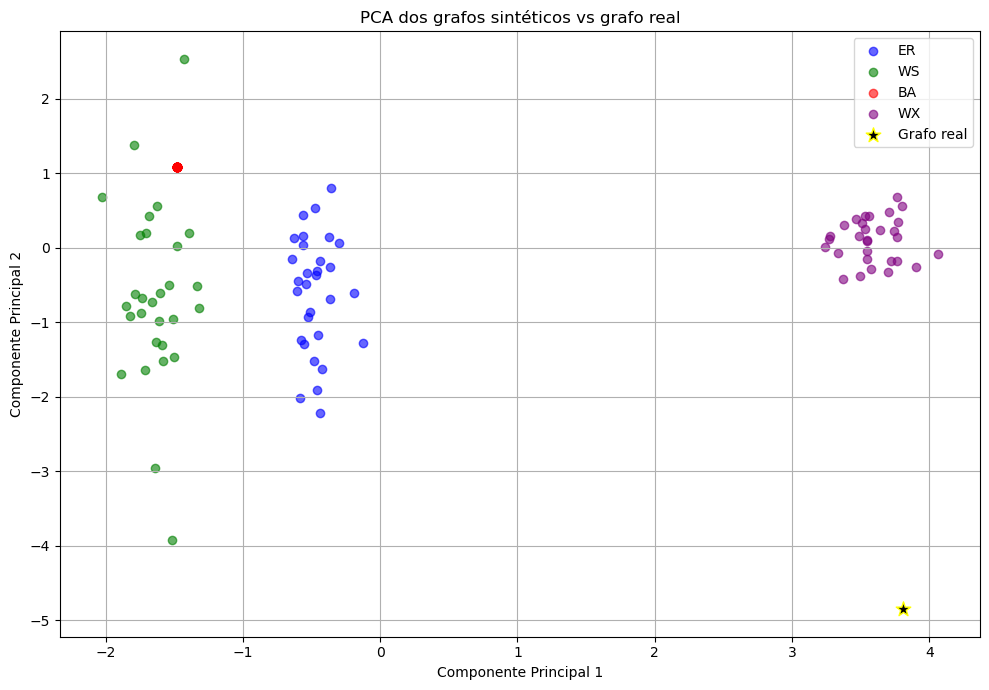

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assume X, y, X_net já foram definidos como no seu código

# Escalar os dados
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

X_net = np.array(X_net).reshape(1, -1)
X_net_scaled = scaler.transform(X_net)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_net_pca = pca.transform(X_net_scaled)

# Plot
plt.figure(figsize=(10, 7))
colors = ['blue', 'green', 'red', 'purple']
labels = ['ER', 'WS', 'BA', 'WX']

for i, color in enumerate(colors):
    idx = np.array(y) == i
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], c=color, label=labels[i], alpha=0.6)

# Plot do grafo real
plt.scatter(X_net_pca[0, 0], X_net_pca[0, 1], c='black', label='Grafo real', edgecolor='yellow', s=120, marker='*')

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA dos grafos sintéticos vs grafo real')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Rede 2 

In [76]:
GB2 = graph_tool_to_networkx(GB2)
GB2, N, M = modify_graph(GB2)
k1,k2,variance,av_cl,l,r = measures(GB2)
X_net = [k1,k2,variance,av_cl,l,r]
X, y = generate_network_data(N=N, av_degree=k1, measures=measures)
X = np.array(X)
y = np.array(y)

Number of nodes: 880
Number of edges: 2296


In [18]:
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

X_net = np.array(X_net)
X_net = X_net.reshape(1, -1)  
X_net = scaler.transform(X_net)
print('Xnet:', X_net.shape)

k = 5
model = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
model.fit(X,y)
# faz a predição no conjunto de teste

Xnet: (1, 6)


KNeighborsClassifier(metric='euclidean')

In [19]:
y_pred = model.predict(X_net) 
print('Classe:', cl[int(y_pred)])

Classe: BA


/var/folders/5p/kzljp9_d39g5r9ykrbtrg00m0000gn/T/ipykernel_46383/278037670.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Classe:', cl[int(y_pred)])


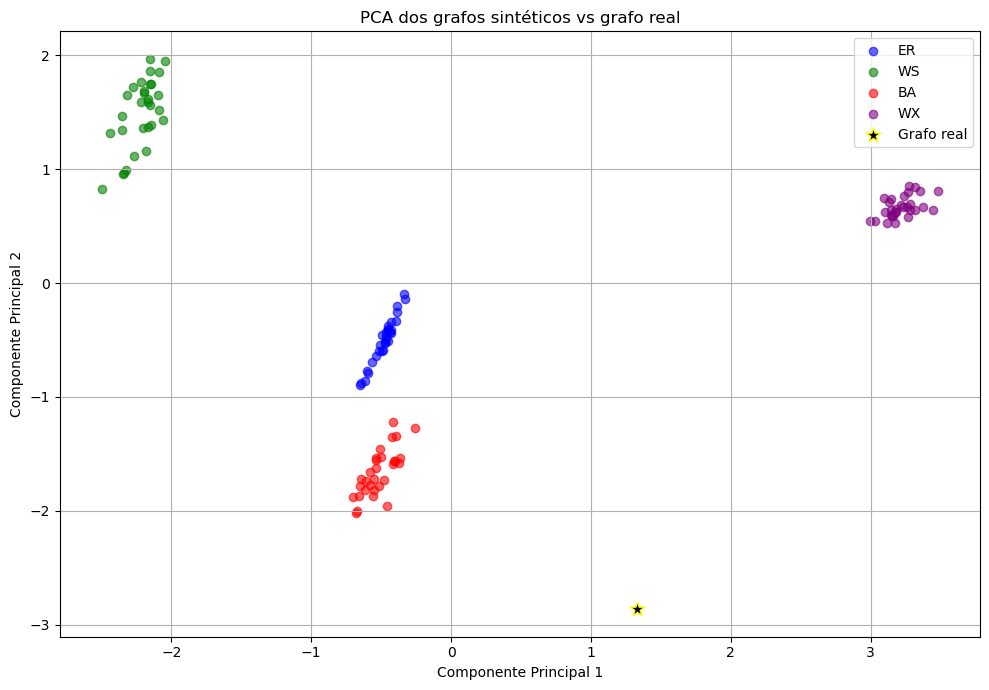

In [20]:
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

X_net = np.array(X_net).reshape(1, -1)
X_net_scaled = scaler.transform(X_net)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_net_pca = pca.transform(X_net_scaled)

# Plot
plt.figure(figsize=(10, 7))
colors = ['blue', 'green', 'red', 'purple']
labels = ['ER', 'WS', 'BA', 'WX']

for i, color in enumerate(colors):
    idx = np.array(y) == i
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], c=color, label=labels[i], alpha=0.6)

# Plot do grafo real
plt.scatter(X_net_pca[0, 0], X_net_pca[0, 1], c='black', label='Grafo real', edgecolor='yellow', s=120, marker='*')

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA dos grafos sintéticos vs grafo real')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Rede 3

In [22]:
GB3 = graph_tool_to_networkx(GB3)
GB3, N, M = modify_graph(GB3)
k1,k2,variance,av_cl,l,r = measures(GB3)
X_net = [k1,k2,variance,av_cl,l,r]
X, y = generate_network_data(N=N, av_degree=k1, measures=measures)
X = np.array(X)
y = np.array(y)

Number of nodes: 664
Number of edges: 1065


In [23]:
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

X_net = np.array(X_net)
X_net = X_net.reshape(1, -1)  
X_net = scaler.transform(X_net)
print('Xnet:', X_net.shape)

k = 5
model = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
model.fit(X,y)
# faz a predição no conjunto de teste

Xnet: (1, 6)


KNeighborsClassifier(metric='euclidean')

In [24]:
X_net = np.array(X_net).reshape(1, -1)  
y_pred = model.predict(X_net)
print('Classe:', cl[int(y_pred[0])])

Classe: BA


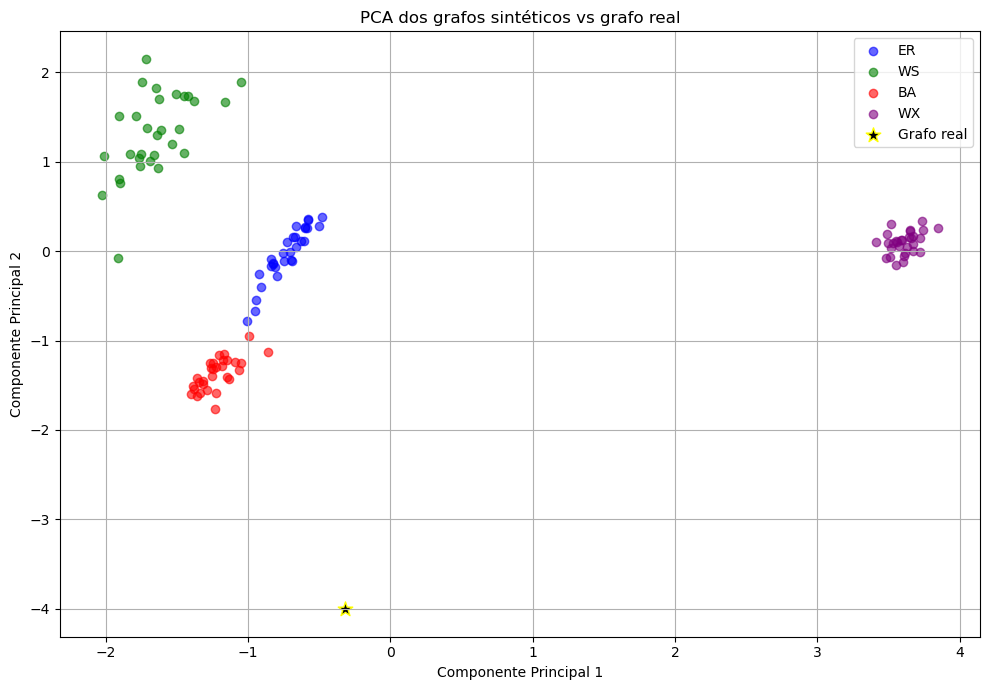

In [25]:
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

X_net = np.array(X_net).reshape(1, -1)
X_net_scaled = scaler.transform(X_net)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_net_pca = pca.transform(X_net_scaled)

# Plot
plt.figure(figsize=(10, 7))
colors = ['blue', 'green', 'red', 'purple']
labels = ['ER', 'WS', 'BA', 'WX']

for i, color in enumerate(colors):
    idx = np.array(y) == i
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], c=color, label=labels[i], alpha=0.6)

# Plot do grafo real
plt.scatter(X_net_pca[0, 0], X_net_pca[0, 1], c='black', label='Grafo real', edgecolor='yellow', s=120, marker='*')

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA dos grafos sintéticos vs grafo real')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Conclusão Biológicas: 
- Rede 1: WX
- Rede 2: BA
- Rede 3: BA

## Sociais

### Rede 1

In [88]:
GS1 = graph_tool_to_networkx(GS1)
GS1, N, M = modify_graph(GS1)
k1,k2,variance,av_cl,l,r = measures(GS1)
X_net = [k1,k2,variance,av_cl,l,r]
X, y = generate_network_data(N=N, av_degree=k1, measures=measures)
X = np.array(X)
y = np.array(y)

Number of nodes: 29
Number of edges: 250


In [90]:
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

X_net = np.array(X_net)
X_net = X_net.reshape(1, -1)  
X_net = scaler.transform(X_net)
print('Xnet:', X_net.shape)

k = 5
model = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
model.fit(X,y)
# faz a predição no conjunto de teste

Xnet: (1, 6)


KNeighborsClassifier(metric='euclidean')

In [92]:
X_net = np.array(X_net).reshape(1, -1)  
y_pred = model.predict(X_net)
print('Classe:', cl[int(y_pred[0])])

Classe: BA


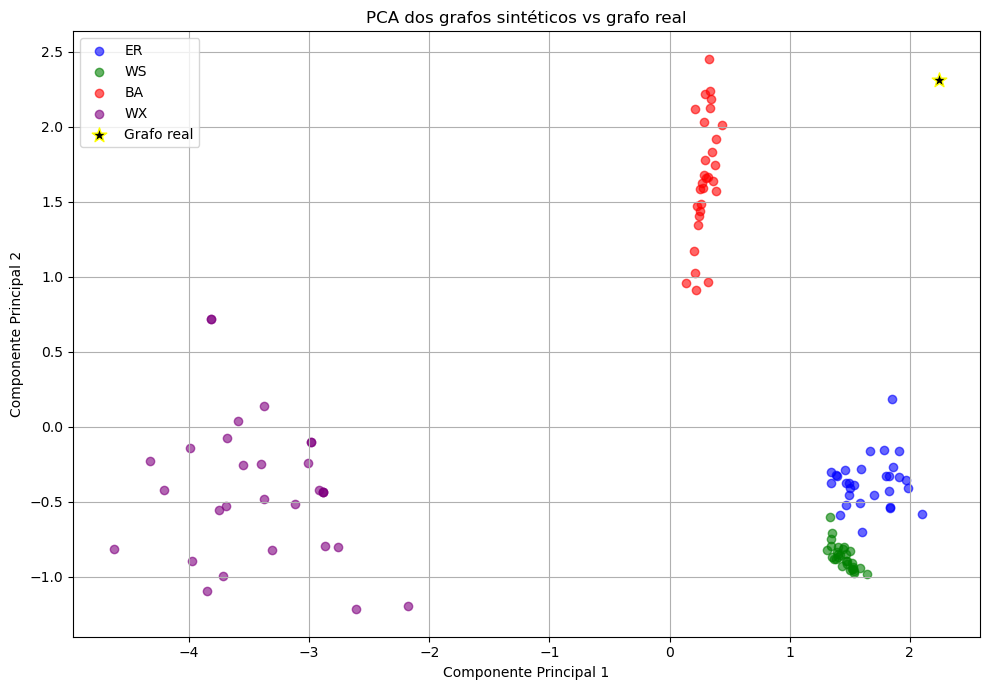

In [94]:
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

X_net = np.array(X_net).reshape(1, -1)
X_net_scaled = scaler.transform(X_net)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_net_pca = pca.transform(X_net_scaled)

# Plot
plt.figure(figsize=(10, 7))
colors = ['blue', 'green', 'red', 'purple']
labels = ['ER', 'WS', 'BA', 'WX']

for i, color in enumerate(colors):
    idx = np.array(y) == i
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], c=color, label=labels[i], alpha=0.6)

# Plot do grafo real
plt.scatter(X_net_pca[0, 0], X_net_pca[0, 1], c='black', label='Grafo real', edgecolor='yellow', s=120, marker='*')

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA dos grafos sintéticos vs grafo real')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Rede 2

In [96]:
GS2 = graph_tool_to_networkx(GS2)
GS2, N, M = modify_graph(GS2)
k1,k2,variance,av_cl,l,r = measures(GS2)
X_net = [k1,k2,variance,av_cl,l,r]
X, y = generate_network_data(N=N, av_degree=k1, measures=measures)
X = np.array(X)
y = np.array(y)

Number of nodes: 179
Number of edges: 184


In [98]:
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

X_net = np.array(X_net)
X_net = X_net.reshape(1, -1)  
X_net = scaler.transform(X_net)
print('Xnet:', X_net.shape)

k = 5
model = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
model.fit(X,y)
# faz a predição no conjunto de teste

Xnet: (1, 6)


KNeighborsClassifier(metric='euclidean')

In [100]:
X_net = np.array(X_net).reshape(1, -1)  
y_pred = model.predict(X_net)
print('Classe:', cl[int(y_pred[0])])

Classe: BA


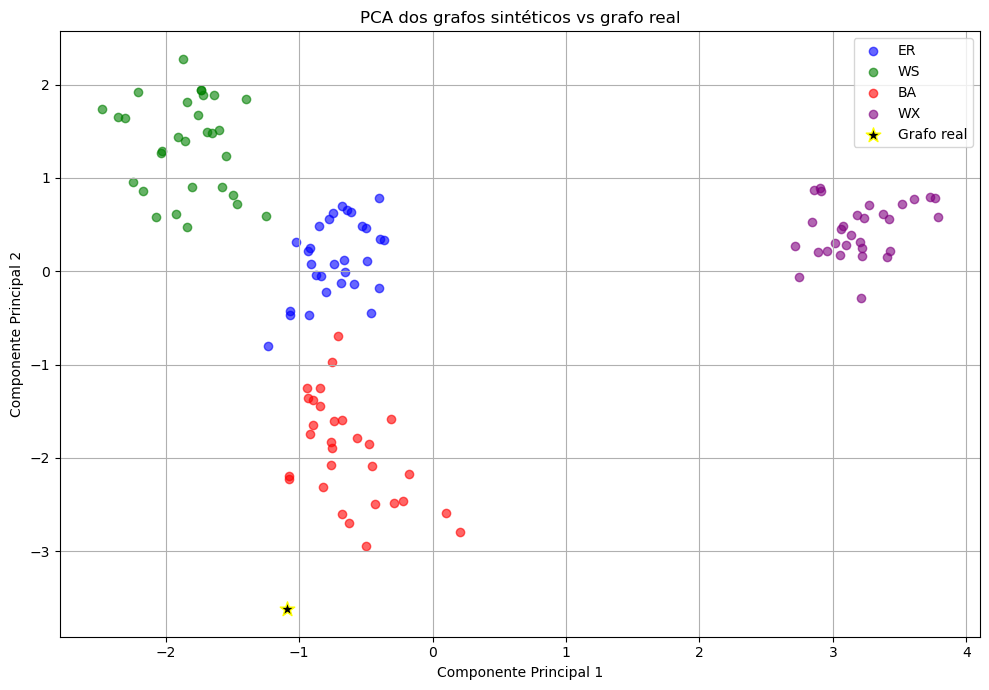

In [102]:
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

X_net = np.array(X_net).reshape(1, -1)
X_net_scaled = scaler.transform(X_net)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_net_pca = pca.transform(X_net_scaled)

# Plot
plt.figure(figsize=(10, 7))
colors = ['blue', 'green', 'red', 'purple']
labels = ['ER', 'WS', 'BA', 'WX']

for i, color in enumerate(colors):
    idx = np.array(y) == i
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], c=color, label=labels[i], alpha=0.6)

# Plot do grafo real
plt.scatter(X_net_pca[0, 0], X_net_pca[0, 1], c='black', label='Grafo real', edgecolor='yellow', s=120, marker='*')

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA dos grafos sintéticos vs grafo real')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Rede 3

In [104]:
GS3 = graph_tool_to_networkx(GS3)
GS3, N, M = modify_graph(GS3)
k1,k2,variance,av_cl,l,r = measures(GS3)
X_net = [k1,k2,variance,av_cl,l,r]
X, y = generate_network_data(N=N, av_degree=k1, measures=measures)
X = np.array(X)
y = np.array(y)

Number of nodes: 62
Number of edges: 159


In [106]:
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

X_net = np.array(X_net)
X_net = X_net.reshape(1, -1)  
X_net = scaler.transform(X_net)
print('Xnet:', X_net.shape)

k = 5
model = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
model.fit(X,y)
# faz a predição no conjunto de teste

Xnet: (1, 6)


KNeighborsClassifier(metric='euclidean')

In [108]:
X_net = np.array(X_net).reshape(1, -1)  
y_pred = model.predict(X_net)
print('Classe:', cl[int(y_pred[0])])

Classe: ER


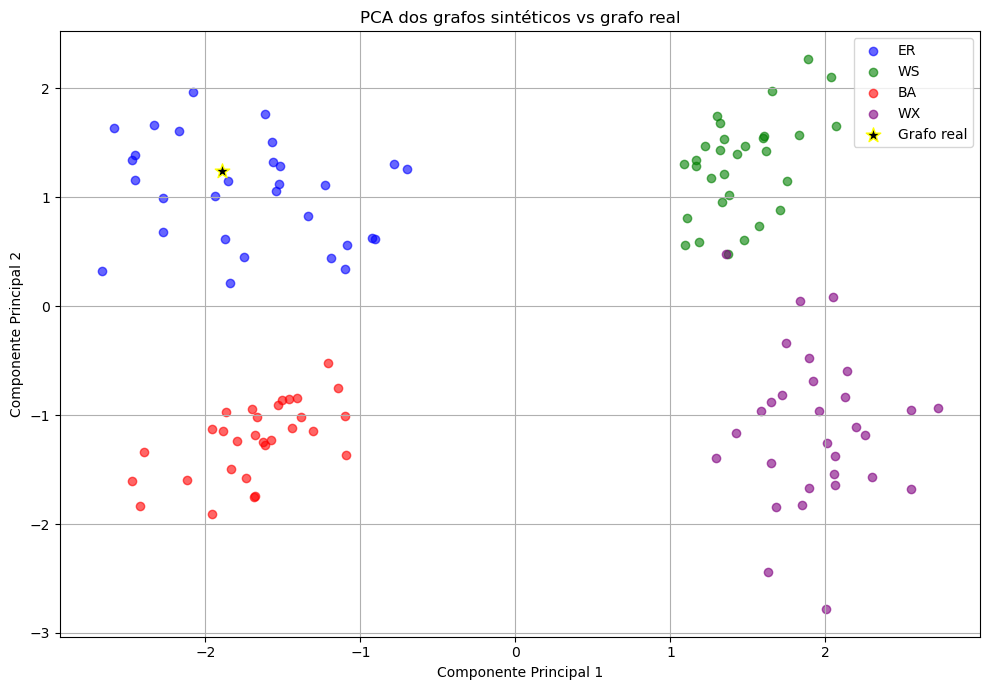

In [110]:
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

X_net = np.array(X_net).reshape(1, -1)
X_net_scaled = scaler.transform(X_net)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_net_pca = pca.transform(X_net_scaled)

# Plot
plt.figure(figsize=(10, 7))
colors = ['blue', 'green', 'red', 'purple']
labels = ['ER', 'WS', 'BA', 'WX']

for i, color in enumerate(colors):
    idx = np.array(y) == i
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], c=color, label=labels[i], alpha=0.6)

# Plot do grafo real
plt.scatter(X_net_pca[0, 0], X_net_pca[0, 1], c='black', label='Grafo real', edgecolor='yellow', s=120, marker='*')

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA dos grafos sintéticos vs grafo real')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Conclusão Social:
- Rede 1: BA
- Rede 2: BA
- Rede 3: ER

## Tecnológica

### Rede 1

In [125]:
GT1 = graph_tool_to_networkx(GT1)
GT1, N, M = modify_graph(GT1)
k1,k2,variance,av_cl,l,r = measures(GT1)
X_net = [k1,k2,variance,av_cl,l,r]
X, y = generate_network_data(N=N, av_degree=k1, measures=measures)
X = np.array(X)
y = np.array(y)


scaler = StandardScaler().fit(X)
X = scaler.transform(X)

X_net = np.array(X_net)
X_net = X_net.reshape(1, -1)  
X_net = scaler.transform(X_net)
print('Xnet:', X_net.shape)

k = 5
model = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
model.fit(X,y)
# faz a predição no conjunto de teste

Number of nodes: 417
Number of edges: 2953
Xnet: (1, 6)


KNeighborsClassifier(metric='euclidean')

In [127]:
X_net = np.array(X_net).reshape(1, -1)  
y_pred = model.predict(X_net)
print('Classe:', cl[int(y_pred[0])])

Classe: BA


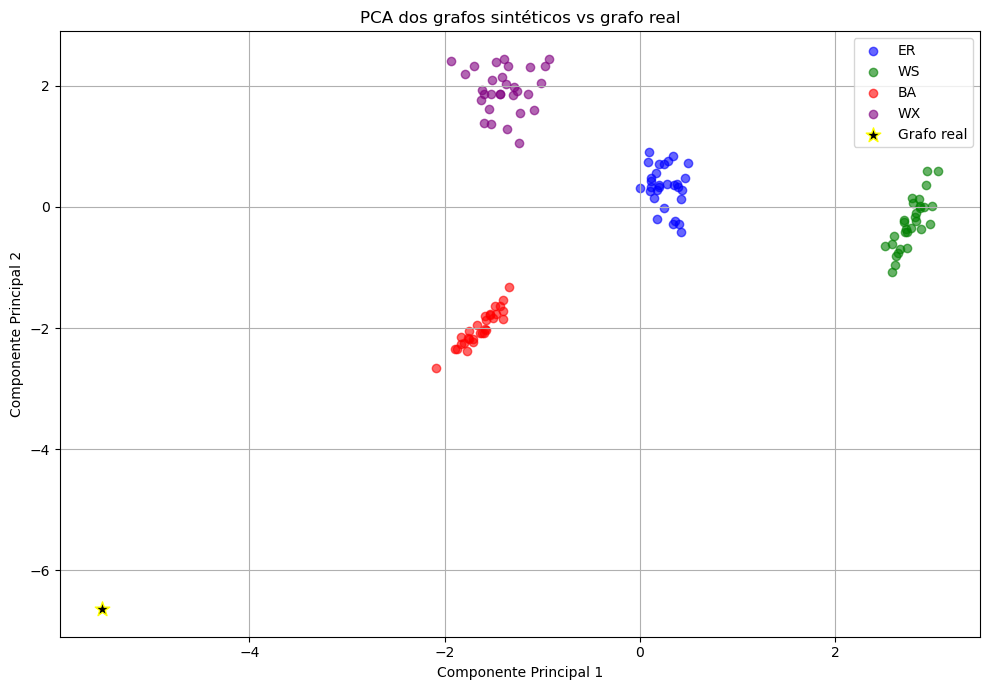

In [129]:
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

X_net = np.array(X_net).reshape(1, -1)
X_net_scaled = scaler.transform(X_net)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_net_pca = pca.transform(X_net_scaled)

# Plot
plt.figure(figsize=(10, 7))
colors = ['blue', 'green', 'red', 'purple']
labels = ['ER', 'WS', 'BA', 'WX']

for i, color in enumerate(colors):
    idx = np.array(y) == i
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], c=color, label=labels[i], alpha=0.6)

# Plot do grafo real
plt.scatter(X_net_pca[0, 0], X_net_pca[0, 1], c='black', label='Grafo real', edgecolor='yellow', s=120, marker='*')

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA dos grafos sintéticos vs grafo real')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Rede 2

In [142]:
GT2 = graph_tool_to_networkx(GT2)
GT2, N, M = modify_graph(GT2)
k1,k2,variance,av_cl,l,r = measures(GT2)
X_net = [k1,k2,variance,av_cl,l,r]
X, y = generate_network_data(N=N, av_degree=k1, measures=measures)
X = np.array(X)
y = np.array(y)


scaler = StandardScaler().fit(X)
X = scaler.transform(X)

X_net = np.array(X_net)
X_net = X_net.reshape(1, -1)  
X_net = scaler.transform(X_net)
print('Xnet:', X_net.shape)

k = 5
model = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
model.fit(X,y)
# faz a predição no conjunto de teste

Number of nodes: 49
Number of edges: 107
Xnet: (1, 6)


KNeighborsClassifier(metric='euclidean')

In [144]:
X_net = np.array(X_net).reshape(1, -1)  
y_pred = model.predict(X_net)
print('Classe:', cl[int(y_pred[0])])

Classe: WS


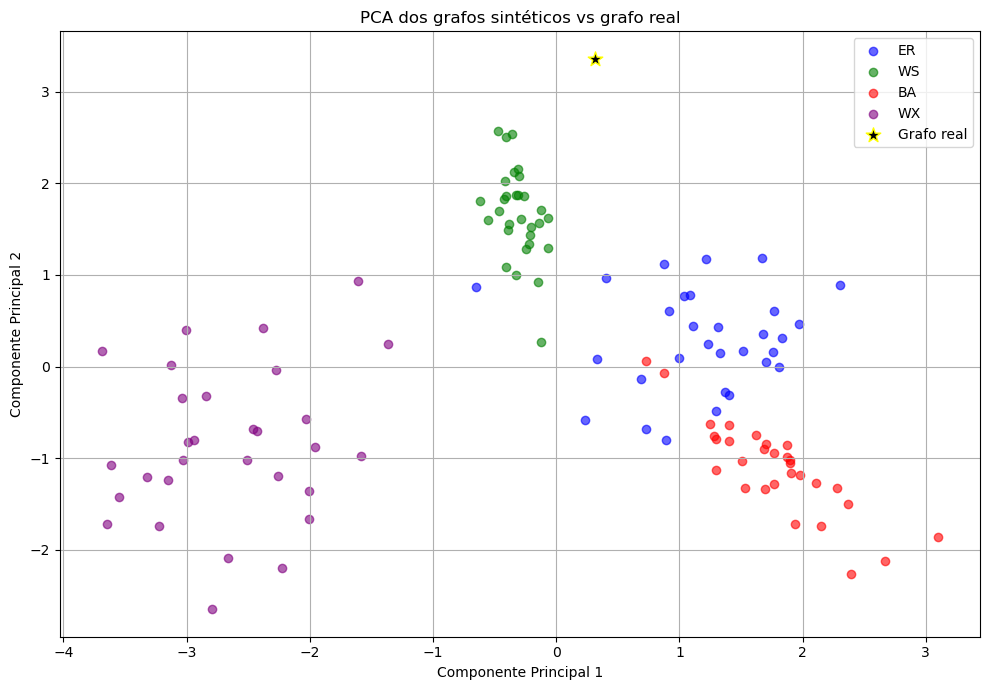

In [146]:
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

X_net = np.array(X_net).reshape(1, -1)
X_net_scaled = scaler.transform(X_net)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_net_pca = pca.transform(X_net_scaled)

# Plot
plt.figure(figsize=(10, 7))
colors = ['blue', 'green', 'red', 'purple']
labels = ['ER', 'WS', 'BA', 'WX']

for i, color in enumerate(colors):
    idx = np.array(y) == i
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], c=color, label=labels[i], alpha=0.6)

# Plot do grafo real
plt.scatter(X_net_pca[0, 0], X_net_pca[0, 1], c='black', label='Grafo real', edgecolor='yellow', s=120, marker='*')

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA dos grafos sintéticos vs grafo real')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Rede 3

In [149]:
GT3 = graph_tool_to_networkx(GT3)
GT3, N, M = modify_graph(GT3)
k1,k2,variance,av_cl,l,r = measures(GT3)
X_net = [k1,k2,variance,av_cl,l,r]
X, y = generate_network_data(N=N, av_degree=k1, measures=measures)
X = np.array(X)
y = np.array(y)


scaler = StandardScaler().fit(X)
X = scaler.transform(X)

X_net = np.array(X_net)
X_net = X_net.reshape(1, -1)  
X_net = scaler.transform(X_net)
print('Xnet:', X_net.shape)

k = 5
model = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
model.fit(X,y)
# faz a predição no conjunto de teste

Number of nodes: 369
Number of edges: 430
Xnet: (1, 6)


KNeighborsClassifier(metric='euclidean')

In [151]:
X_net = np.array(X_net).reshape(1, -1)  
y_pred = model.predict(X_net)
print('Classe:', cl[int(y_pred[0])])

Classe: ER


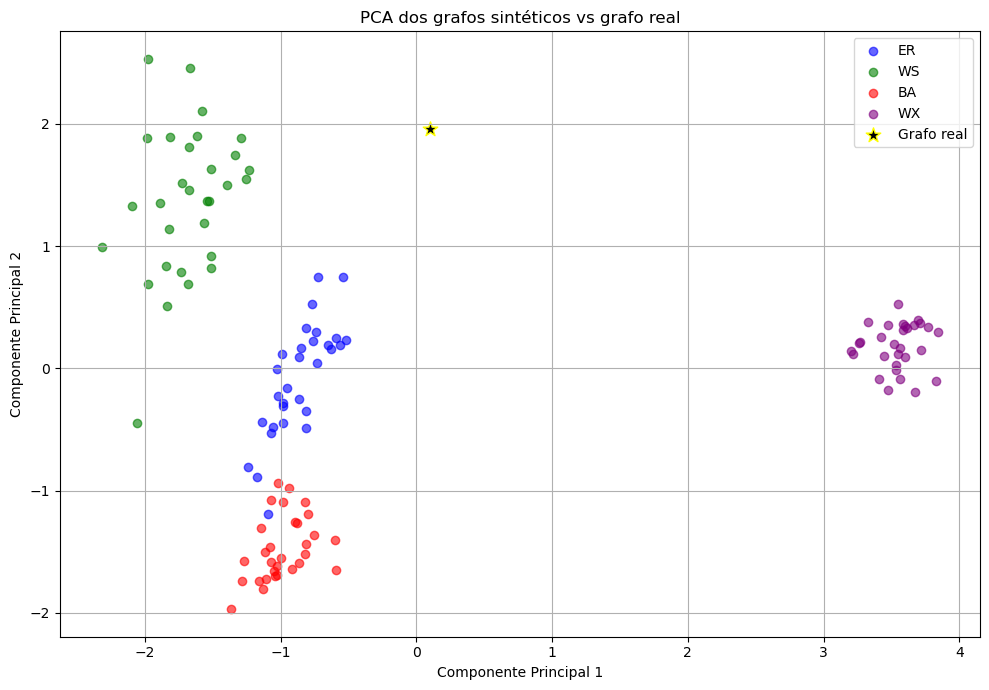

In [153]:
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

X_net = np.array(X_net).reshape(1, -1)
X_net_scaled = scaler.transform(X_net)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_net_pca = pca.transform(X_net_scaled)

# Plot
plt.figure(figsize=(10, 7))
colors = ['blue', 'green', 'red', 'purple']
labels = ['ER', 'WS', 'BA', 'WX']

for i, color in enumerate(colors):
    idx = np.array(y) == i
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], c=color, label=labels[i], alpha=0.6)

# Plot do grafo real
plt.scatter(X_net_pca[0, 0], X_net_pca[0, 1], c='black', label='Grafo real', edgecolor='yellow', s=120, marker='*')

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA dos grafos sintéticos vs grafo real')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Conclusão Tecnologia:
- Rede 1: BA
- Rede 2: WS
- Rede 3: ER

## Hipótese: redes do mesmo tipo (biológica, social e tecnológica) seguem o mesmo modelo.

Nota-se que a partir da classificação das redes estudadas, elas não seguem um modelo em comum, portanto, não se pode dizer que cada tipo de rede segue um modelo igual.